In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, cv2, glob
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Activation, Concatenate
from keras import Model, Input
from keras.utils import plot_model
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [26]:
dataset_txt = r"C:\Users\Dell\Desktop\data\Houses-dataset-master\Houses Dataset\HousesInfo.txt"
dataset_image = r"C:\Users\Dell\Desktop\data\Houses-dataset-master\Houses Dataset"
columns_nam = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(dataset_txt, sep=" ", header=None, names=columns_nam)

In [27]:
zipcodes, counts = np.unique(df["zipcode"], return_counts=True)
for zipcode, count in zip(zipcodes, counts):
    if count < 25:
        df = df[df["zipcode"] != zipcode]

In [59]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,5,3.0,2520,93446,789000
1,3,2.0,1802,93446,365000
2,3,3.0,2146,93446,455000
3,4,2.5,2464,91901,599000
4,2,2.0,1845,91901,529800


In [61]:
df['price'].max(), df['price'].min()

(5858000, 36000)

In [56]:
df['zipcode'].value_counts()

zipcode
92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
Name: count, dtype: int64

In [28]:
images = []
valid_indices = []

for i in df.index.values:
    house_img_pattern = os.path.sep.join([dataset_image, '{}_*'.format(i+1)])
    img_sorted = sorted(glob.glob(house_img_pattern))
    
    if len(img_sorted) >= 4:
        inp_image = []
        for image_path in img_sorted[:4]:
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.resize(img, (32, 32))
                inp_image.append(img)
        if len(inp_image) == 4:
            out_image = np.zeros((64, 64, 3), dtype='uint8')
            out_image[0:32, 0:32] = inp_image[0]
            out_image[0:32, 32:64] = inp_image[1]
            out_image[32:64, 32:64] = inp_image[2]
            out_image[32:64, 0:32] = inp_image[3]
            images.append(out_image)
            valid_indices.append(i)

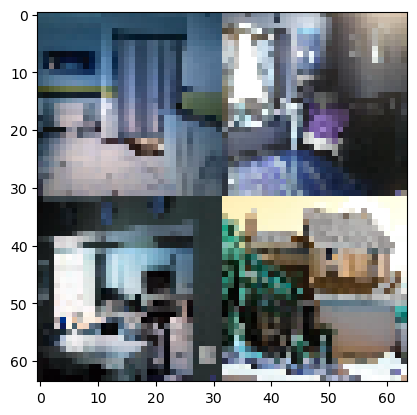

In [57]:
plt.imshow(images[2])

In [29]:
df = df.loc[valid_indices].reset_index(drop=True)
images = np.array(images)

In [30]:
X = df.drop("price", axis=1)
y = df["price"].values
train_txt, test_txt, train_img, test_img, y_train, y_test = train_test_split(
    X, images, y, test_size=0.2, random_state=42)

In [31]:
maxPrice = y_train.max()
trainY = y_train / maxPrice
testY = y_test / maxPrice

In [32]:
cols = ["bedrooms", "bathrooms", "area"]
cs = MinMaxScaler()
train_cols = cs.fit_transform(train_txt[cols])
test_cols = cs.transform(test_txt[cols])

In [33]:
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
train_zip = zipBinarizer.transform(train_txt["zipcode"])
test_zip = zipBinarizer.transform(test_txt["zipcode"])

In [34]:
train_txt_scaled = np.hstack([train_zip, train_cols])
test_txt_scaled = np.hstack([test_zip, test_cols])

In [35]:
image_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, height_shift_range=0.2, width_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [36]:
train_img = np.array(train_img).astype("float32") / 255.0
test_img = np.array(test_img).astype("float32") / 255.0

train_img_aug = image_aug.flow(train_img, trainY, batch_size=32, shuffle=True)

In [37]:
test_img = test_img.astype("float32") / 255.0

In [38]:
def build_structured_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    return Model(inputs, x)

In [39]:
def build_image_model():
    baseModel = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))
    for layer in baseModel.layers:
        layer.trainable = False
    x = baseModel.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(baseModel.input, x)

In [40]:
structured_model = build_structured_model(train_txt_scaled.shape[1])
image_model = build_image_model()

combined_input = Concatenate()([structured_model.output, image_model.output])
x = Dense(64, activation="relu")(combined_input)
x = Dense(1)(x) 

model = Model(inputs=[structured_model.input, image_model.input], outputs=x)

In [41]:
model.compile(optimizer=Adam(1e-4), loss="mean_absolute_error")

In [42]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence

def combined_generator(image_gen, structured_data):
    while True:
        img_batch, label_batch = next(image_gen)
        batch_size = img_batch.shape[0]
        idxs = np.random.randint(0, structured_data.shape[0], size=batch_size)
        struct_batch = structured_data[idxs]
        yield (struct_batch, img_batch), label_batch


train_dataset = tf.data.Dataset.from_generator(lambda: combined_generator(train_img_aug, train_txt_scaled), output_signature=((tf.TensorSpec(shape=(None, train_txt_scaled.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),),tf.TensorSpec(shape=(None,), dtype=tf.float32)))



In [43]:
steps_per_epoch = len(train_img) // 32

history= model.fit(train_dataset, validation_data=([test_txt_scaled, test_img], testY), steps_per_epoch=steps_per_epoch, epochs=100)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - loss: 0.1632 - val_loss: 0.1434
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1366 - val_loss: 0.1175
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.1008 - val_loss: 0.0926
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.0955 - val_loss: 0.0692
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.0796 - val_loss: 0.0516
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0509 - val_loss: 0.0431
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.0629 - val_loss: 0.0415
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0550 - val_loss: 0.0426
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0511 - val_loss: 0.0431
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0490 - val_loss: 0.0438
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.0505 - val_loss: 0.0455
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.

<Figure size 640x480 with 0 Axes>

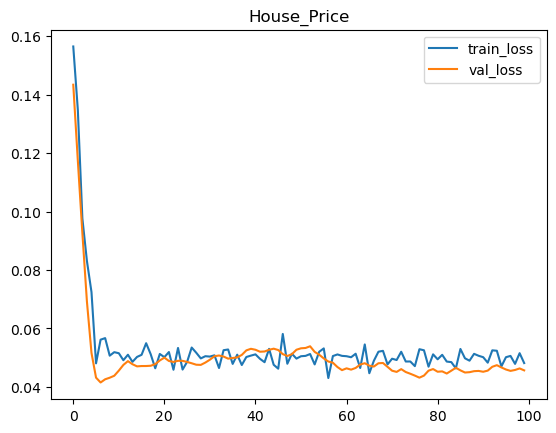

<Figure size 640x480 with 0 Axes>

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('House_Price')
plt.figure()


In [84]:
predicted_scaled = model.predict([test_txt_scaled, test_img])


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


In [99]:
testY[0:5]

array([0.08706043, 0.1142028 , 0.16712188, 0.13127347, 0.1109423 ])

In [100]:
predicted_scaled[0:5]

array([0.07952718, 0.0907314 , 0.08673875, 0.08013757, 0.08390214],
      dtype=float32)

In [101]:
diff= testY-predicted_scaled
diff.max(), diff.min()

(0.21770344346955028, -0.07533410267440806)

In [102]:
predicted_scaled = predicted_scaled.flatten()
mse = mean_squared_error(testY, predicted_scaled)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0038
